# Initialize data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
from airpyllution.airpyllution import get_air_pollution
from airpyllution.airpyllution import get_pollution_history

In [55]:
# Load the generated grid of points (spacing of 1 degree)
grid = gpd.read_file(r'path')

# Spatial filter a little over the 55th parallel. 
grid = grid[grid['top'] < 55.24]

In [89]:
# Max's outputs of risk scores and average AQHI
df = pd.read_csv(r'path')

In [10]:
df.isna().any()

hive_id            False
aqhi_average_og    False
prediction         False
dtype: bool

# Extract 2024 air quality from OpenWeather API

In [ ]:
import datetime

# Créez un objet datetime
date = datetime.datetime(2024, 4, 1, 0, 0, 0)  # Exemple : 1er juin 2022 à minuit (00:00:00)

# Utilisez la méthode timestamp() pour obtenir le timestamp UNIX correspondant
apr_unix = date.timestamp()

apr_unix = int(apr_unix)

# Imprimez le timestamp UNIX
print(apr_unix)

1711922400


In [ ]:
# Créez un objet datetime
date = datetime.datetime(2024, 9, 1, 0, 0, 0)  # Exemple : 1er novembre 2022 à minuit (00:00:00)

# Utilisez la méthode timestamp() pour obtenir le timestamp UNIX correspondant
sept_unix = int(date.timestamp())


# Imprimez le timestamp UNIX
print(sept_unix)


# Utilisez la méthode fromtimestamp de la classe datetime pour effectuer la conversion
date = datetime.datetime.fromtimestamp(sept_unix)

# Imprimez la date au format lisible
print(date)

1725141600
2024-09-01 00:00:00


In [ ]:
import time

# Extract AQHI data (Aware that df.iterrows is not recommended but reused old code)
for i, row in grid.iterrows():
    lat = row['geometry'].y
    lon = row['geometry'].x

    # récupère les données d'AQI en dataframe pour chaque point du gdf_cluster
    data = get_pollution_history(apr_unix, sept_unix, lat, lon, '<api_key>')

    if data is not None and not data.empty:
        # stocke les valeurs d'AQI
        grid.at[i, 'mean_pm2_5_e2024'] = data['pm2_5'].mean()
        grid.at[i, 'mean_pm10_e2024'] = data['pm10'].mean()
        grid.at[i, 'mean_o3_e2024'] = data['o3'].mean()
        grid.at[i, 'mean_no2_e2024'] = data['no2'].mean()
        grid.at[i, 'mean_co_e2024'] = data['co'].mean()
        grid.at[i, 'mean_nh3_e2024'] = data['nh3'].mean()
        grid.at[i, 'mean_so2_e2024'] = data['so2'].mean()

        # 1 second delay car limite de l'API < 60 req par min.
        time.sleep(1)


In [81]:
grid.isna().sum()

id                  0
left                0
top                 0
right               0
bottom              0
mean_pm2_5_e2024    0
mean_pm10_e2024     0
mean_o3_e2024       0
mean_no2_e2024      0
mean_co_e2024       0
mean_nh3_e2024      0
mean_so2_e2024      0
geometry            0
dtype: int64

## Calculate AQHI

In [84]:
import math
# # To gen the 3h avg
# for aqhi_col in ['o3','no2','pm2_5']:
#     aqi_data[f'3h_{aqhi_col}_avg'] = aqi_data[aqhi_col].rolling(window=3).mean()

# Canadian AQHI function (Nico)
@staticmethod
def aqhi(x):
    """Calculate the AQHI (ref: https://www.tandfonline.com/doi/abs/10.3155/1047-3289.58.3.435)
    Need to create the past 3 hour average on the AQI raw data. You can do this this way:
    - df[col].rolling(window=3).mean()
    """
    const = 10 / 10.4
    e = math.e
    aqhi = const * 100 * (
        (
              (e ** (0.000537 * x["mean_o3_e2024"]) - 1)
            + (e ** (0.000871 * x["mean_no2_e2024"]) - 1)
            + (e ** (0.000487 * x["mean_pm2_5_e2024"]) - 1)
        )
    )
    #return round(aqhi, 0) pas nécessaire d'arrondir pour cartographier
    return aqhi

In [85]:
# Apply the AQHI calculation
grid['aqhi'] = grid.apply(lambda x: aqhi(x),axis=1)

In [91]:
df.rename(columns={'aqhi_average_og':'aqhi','prediction':'risk_score'},inplace=True)

In [92]:
df.describe()

,hive_id,aqhi,risk_score
count,112626.000000,112626.000000,112626.000000
mean,108971.258555,3.362000,1121.046495
std,52208.286251,0.889078,41.583284
min,12449.000000,1.000000,673.844459
25%,64209.250000,2.683359,1077.485649
50%,116518.500000,3.051948,1108.449104
75%,151828.750000,4.216802,1168.043658
max,197100.000000,6.000000,1462.103953


In [93]:
df.sort_values(by='risk_score').head()

,hive_id,aqhi,risk_score
99447,153066,3.000000,673.844459
1407,16904,2.070707,1059.631255
3216,16894,1.932927,1059.631255
98136,180493,2.076190,1059.631255
15180,71577,2.096386,1059.631255


In [94]:
df.sort_values(by='aqhi',ascending=True).head()

,hive_id,aqhi,risk_score
109562,192487,1.0,1117.565317
27325,81689,1.0,1072.726327
27538,82865,1.0,1072.726327
26761,82864,1.0,1072.726327
108081,196148,1.0,1117.565317


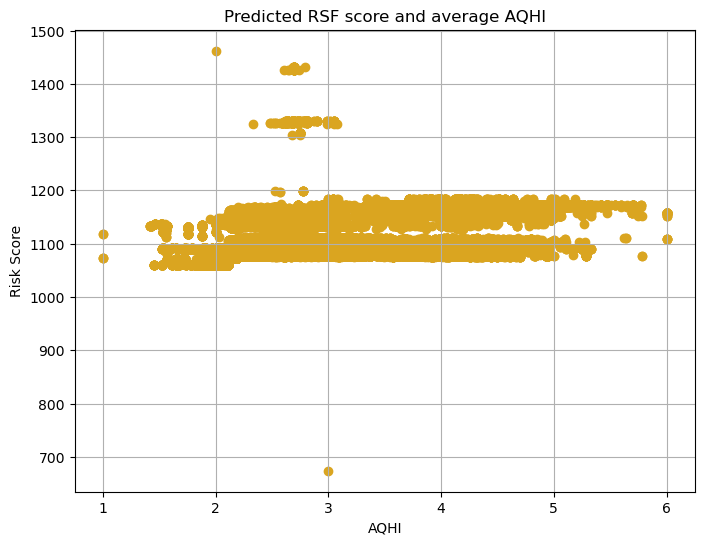

In [95]:
import matplotlib.pyplot as plt

# Scatter plot of risk scores vs AQHI
plt.figure(figsize=(8, 6))
plt.scatter(df['aqhi'], df['risk_score'], color='goldenrod')
plt.xlabel('AQHI')
plt.ylabel('Risk Score')
plt.title('Predicted RSF score and average AQHI')
plt.grid(True)
plt.show()

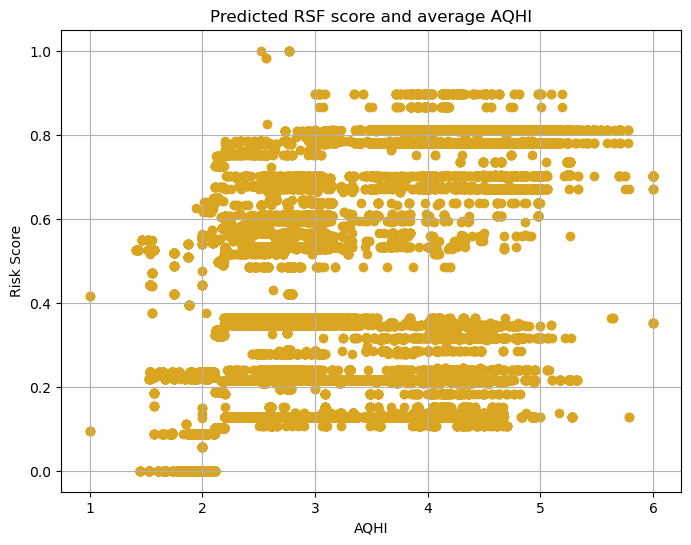

In [149]:
# Rule out outlier values
df = df[(df['risk_score'] > 700) & (df['risk_score'] < 1300)]

# Normalizing between 0 and 1
scaler = MinMaxScaler()
df['risk_score'] = scaler.fit_transform(df[['risk_score']])

#Plotting again
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['aqhi'], df['risk_score'], color='goldenrod')
plt.xlabel('AQHI')
plt.ylabel('Risk Score')
plt.title('Predicted RSF score and average AQHI')
plt.grid(True)
plt.show()

# Extrapolation

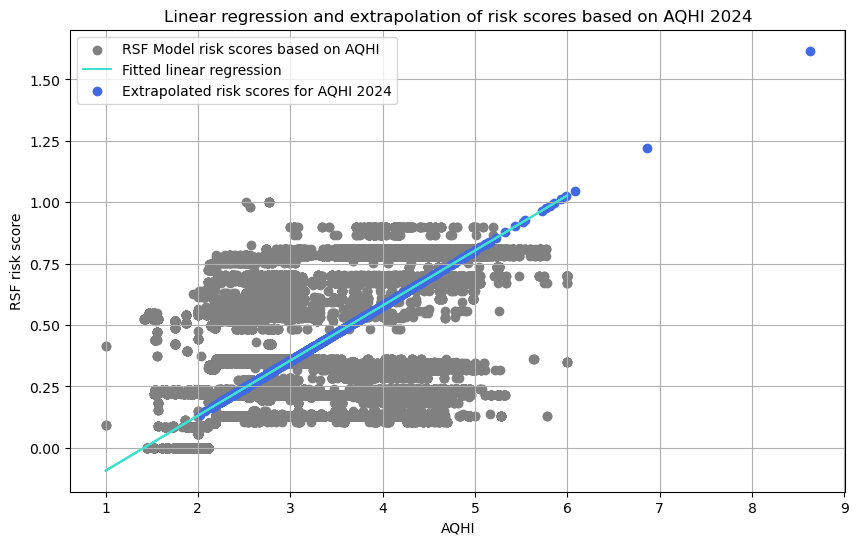

In [186]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load predict rsf data
X = df[['aqhi']].values
y = df['risk_score'].values

# # Add a polynomial term?
# # Polynomial degree (1 for linear reg, 2 for quadratic, etc)
# degree = 2

# # Fit a polynomial regression model
# poly = PolynomialFeatures(degree=degree)
# X_poly = poly.fit_transform(X)
# model.fit(X_poly, y)

model = LinearRegression()
model.fit(X, y)

# Extrapolate on the grid AQHI values for 2024
aqhi_grid = grid[['aqhi']].values
# X_poly_test = poly.transform(X_test)
grid['risk_score'] = model.predict(aqhi_grid)

# Scatter plot of the points + regression
plt.figure(figsize=(10, 6))

# Scatter original points
plt.scatter(df['aqhi'], df['risk_score'], color='grey', label='RSF Model risk scores based on AQHI')

# Regression line
plt.plot(df['aqhi'], model.predict(X), color='turquoise', label=f'Fitted linear regression')

# Scatter extrapolated points
plt.scatter(grid['aqhi'], grid['risk_score'], color='royalblue', label='Extrapolated risk scores for AQHI 2024')
plt.xlabel('AQHI')
plt.ylabel('RSF risk score')
plt.title('Linear regression and extrapolation of risk scores based on AQHI 2024')
plt.legend()
plt.grid(True)
plt.show()


OK but extreme outlier pred and risk score goes under 0 at low AQHI.

Compare fit with another regressor, elastic net

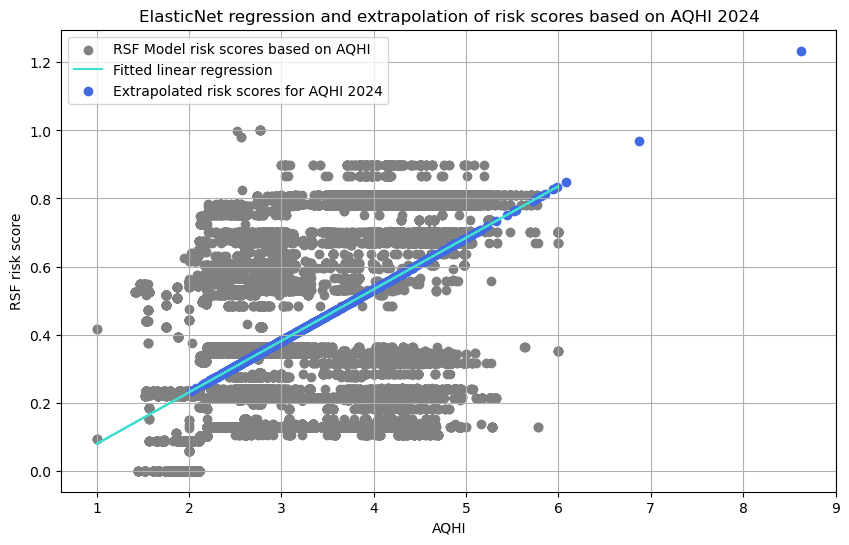

In [187]:
from sklearn.linear_model import ElasticNet

# Load predict rsf data
X = df[['aqhi']].values
y = df['risk_score'].values

# Fit an ElasticNet regressor
model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1)
model.fit(X, y)

# Extrapolate on the grid AQHI values for 2024
aqhi_grid = grid[['aqhi']].values
grid['risk_score'] = model.predict(aqhi_grid)

# Scatter plot of the points + regression
plt.figure(figsize=(10, 6))

# Scatter original points
plt.scatter(df['aqhi'], df['risk_score'], color='grey', label='RSF Model risk scores based on AQHI')

# Regression line
plt.plot(df['aqhi'], model.predict(X), color='turquoise', label=f'Fitted linear regression')

# Scatter extrapolated points
plt.scatter(grid['aqhi'], grid['risk_score'], color='royalblue', label='Extrapolated risk scores for AQHI 2024')
plt.xlabel('AQHI')
plt.ylabel('RSF risk score')
plt.title('ElasticNet regression and extrapolation of risk scores based on AQHI 2024')
plt.legend()
plt.grid(True)
plt.show()


Seems to fit better

In [188]:
grid['risk_score'].max()

# Goes over 1 so let's standardize

np.float64(1.2340979093183775)

In [181]:
grid.dtypes

id                          int32
left                      float64
top                       float64
right                     float64
bottom                    float64
mean_pm2_5_e2024          float64
mean_pm10_e2024           float64
mean_o3_e2024             float64
mean_no2_e2024            float64
mean_co_e2024             float64
mean_nh3_e2024            float64
mean_so2_e2024            float64
geometry                 geometry
aqhi                      float64
risk_score                float64
risk_score_normalized     float64
dtype: object

## Standardize final risk scores

In [169]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [189]:
# normalizing between 0 and 1
scaler = MinMaxScaler()
grid['risk_score_normalized'] = scaler.fit_transform(grid[['risk_score']])

In [190]:
grid.describe()

,id,left,top,right,bottom,mean_pm2_5_e2024,mean_pm10_e2024,mean_o3_e2024,mean_no2_e2024,mean_co_e2024,mean_nh3_e2024,mean_so2_e2024,aqhi,risk_score,risk_score_normalized
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,4990.910247,-95.629555,43.824115,-94.629555,44.824115,3.555468,5.116030,64.917274,-4.147847,207.241399,0.962445,0.387287,3.232852,0.416960,0.183711
std,1114.400881,17.153261,7.245647,17.153261,7.245647,1.841605,3.733861,11.044090,1.573122,21.917325,0.960777,0.542655,0.692698,0.104908,0.104799
min,614.000000,-162.791111,25.233240,-161.791111,26.233240,0.696213,0.774467,45.485750,-5.414925,155.441397,0.001784,0.008184,2.018567,0.233057,0.000000
25%,4080.000000,-109.791111,38.233240,-108.791111,39.233240,2.173194,2.337021,56.453422,-5.036357,193.784465,0.124481,0.084383,2.700390,0.336319,0.103154
50%,4970.000000,-95.791111,44.233240,-94.791111,45.233240,3.312401,4.332897,62.136363,-4.506828,206.724675,0.737898,0.201375,3.098873,0.396669,0.163441
75%,5827.000000,-82.791111,50.233240,-81.791111,51.233240,4.496956,6.213439,71.547607,-3.871500,221.632472,1.588002,0.477005,3.667726,0.482821,0.249504
max,7707.000000,-53.791111,55.233240,-52.791111,56.233240,25.470011,33.475791,121.082823,13.401857,324.057833,12.231059,6.720901,8.628315,1.234098,1.000000


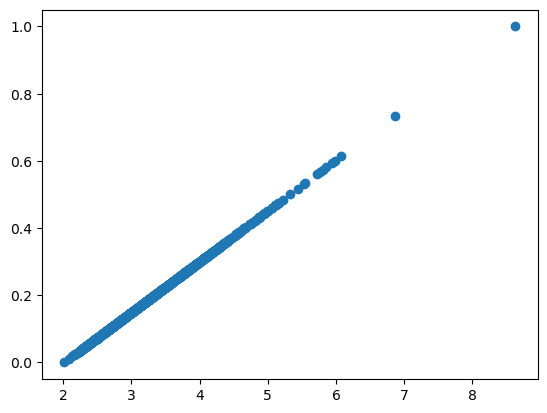

In [191]:
plt.figure()
plt.scatter(grid['aqhi'],grid['risk_score_normalized'])

# export extrapolated grid

In [192]:
grid.to_file(r'path',driver='GeoJSON')